<a href="https://colab.research.google.com/github/lim-jr/ESAA-Submits/blob/main/0515%EC%9B%94%EA%B3%BC%EC%A0%9C_%EC%99%84%EB%B2%BD%EA%B0%80(579_590)_%EC%B6%94%EC%B2%9C%EC%8B%9C%EC%8A%A4%ED%85%9C%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 5. 콘텐츠 기반 필터링 실습 -TMDB5000 영화 데이터셋

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/ESAA/데이터셋")

## 5.1 장르 속성을 이용한 영화 **콘텐츠 기반 필터링**

* 콘텐츠 기반 필터링 
  * 사용자가 특정 영화를 감상하고 그 영화를 좋아했다면 그 영화와 비슷한 특성/속성, 구성요소 등을 가진 다른 영화를 추천
  * 영화 간 유사성을 판단하는 기준이 영화를 구성하는 다양한 콘텐츠(장르, 감독, 배우, 키워드)를 기반으로 함

* 이 예제에서 '장르' 속성 기반으로, 콘텐츠기반 필터링 추천시스템을 만들어보겠다.

### 5.1.1 데이터 로딩 및 가공

In [15]:
import pandas as pd
import numpy as np
import warnings; warnings.filterwarnings('ignore')

movies = pd.read_csv('./tmdb_5000_movies.csv')
print(movies.shape)
movies.head(3)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp...",en,Avatar,"In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, ...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289}, {""name"": ""Twentieth Century Fox Film Corporatio...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}, {""iso_3166_1"": ""GB"", ""name"": ""United ...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic is...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of t...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""name"": ""Jerry Bruckheimer Films"", ""id"": 130}, {""na...","[{""iso_3166_1"": ""US"", ""name"": ""United States of America""}]",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 80, ""name"": ""Crime""}]",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name"": ""based on novel""}, {""id"": 4289, ""name"": ""secret...",en,Spectre,A cryptic message from Bond’s past sends him on a trail to uncover a sinister organization. Whil...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""name"": ""Danjaq"", ""id"": 10761}, {""name"": ""B24"", ""id"": ...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}, {""iso_3166_1"": ""US"", ""name"": ""United States of ...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""}, {""iso_639_1"": ""en"", ""name"": ""English""}, {""iso_639...",Released,A Plan No One Escapes,Spectre,6.3,4466


In [16]:
# 콘텐츠 기반 필터링 추천 분석에 사용할 주요 칼럼만 추출
movies_df=movies[['id', 'title', 'genres', 'vote_average', 'vote_count', 'popularity', 'keywords', 'overview']]

In [8]:
# genres 칼럼은 여러 개 개별장르 데이터를 가지고 있음

pd.set_option('max_colwidth', 100)
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp..."


In [17]:
# 문자열 분해해서 개별 장르를 파이썬 리스트 객체로 추출

from ast import literal_eval
movies_df['genres'] = movies_df['genres'].apply(literal_eval)
movies_df['keywords'] = movies_df['keywords'].apply(literal_eval)

print(movies_df['genres'][:1])

0    [{'id': 28, 'name': 'Action'}, {'id': 12, 'name': 'Adventure'}, {'id': 14, 'name': 'Fantasy'}, {...
Name: genres, dtype: object


In [18]:
# 리스트 내 여러개의 딕셔너리의 'name'키에 해당하는 값을 찾아 반환

movies_df['genres'] = movies_df['genres'].apply(lambda x : [y ['name'] for y in x])
movies_df['keywords'] = movies_df['keywords'].apply(lambda x : [y['name'] for y in x])
movies_df[['genres', 'keywords']][:1]

,genres,keywords
0,"[Action, Adventure, Fantasy, Science Fiction]","[culture clash, future, space war, space colony, society, space travel, futuristic, romance, spa..."


### 5.1.2. 장르 콘텐츠 유사도 측정
* 유사독 측정하는 가장 간단한 방법 
  * genres를 문자열로 변경한 뒤, countvectorizer로 피처 벡터화한 행렬 데이터 값을 코사인 유사도로 비교

  1. 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환
  2. genres 문자열을 피처 벡터화 행렬로 변환한 데이터 세트를 코사인 유사도를 통해 비교.     
  이를 위해 데이터 세트의 레코드 별로 타 레코드와 장르에서 코사인 유사도 값을 가지는 객체 생성
  3. 장르 유사도가 높은 영화 중에 평점이 높은 순으로 영화를 추천

In [22]:
# 1. 문자열로 변환된 genres 칼럼을 Count 기반으로 피처 벡터화 변환

from sklearn.feature_extraction.text import CountVectorizer

# CountVectorizer를 적용하기 위해 공백문자로 word 단위가 구분되는 문자열로 변환.
movies_df['genres_literal'] = movies_df['genres'].apply(lambda x : (' ').join(x))
print(movies_df['genres_literal'][:1])
count_vect = CountVectorizer(min_df=0, ngram_range=(1,2))
genre_mat = count_vect.fit_transform(movies_df['genres_literal'])
print(genre_mat.shape)

0    Action Adventure Fantasy Science Fiction
Name: genres_literal, dtype: object


In [21]:
# 2. 코사인 유사도 계산

from sklearn.metrics.pairwise import cosine_similarity

genre_sim = cosine_similarity(genre_mat, genre_mat)
print(genre_sim.shape)
print(genre_sim[:1])

(4803, 4803)
[[1.         0.59628479 0.4472136  ... 0.         0.         0.        ]]


* genre_sim 객체는 movie_df의 genre_literal 칼럼을 피처 벡터화한 행렬(genre_mat) 데이터의 행 별 유사도 정보를 가지고 있으며, 결국은 movie_df의 행 별 장르 유사도 값을 가지고 있음

In [23]:
# genre_sim 객체의 기준 행별로 비교 대상이 되는 행의 유사도 값이 
# 높은 순으로 정렬된 행렬의 위치 인덱스 값 중 
# 0번 레코드의 비교행 위치인덱스 값을 추출

genre_sim_sorted_ind = genre_sim.argsort()[:, ::-1]
print(genre_sim_sorted_ind[:1])

[[   0 3494  813 ... 3038 3037 2401]]


* 0번 레코드의 경우, 3494번 레코드와 가장 유사도가 높고 그 다음 813번 레코드이며, 가장 유사도가 낮은 레코드는 2401번 레코드임


### 5.1.3 장르 콘텐츠 필터링을 이용한 영화 추천
* 영화를 추천하는 함수 생성 


In [24]:
def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  # 인자로 입력된 movies_df DataFrame에서 'title' 칼럼이 입력된 title_name 값인 DataFrame 추출
  title_movie = df[df['title'] == title_name]

  # title_named을 가진 DataFrame의 index 객체를 ndarray로 변환하고
  # sorted_ind 인자로 입력된 genre_sim_sorted_ind 객체에서 유사도 순으로 top_n개의 index 추출
  title_index = title_movie.index.values
  similar_indexes = sorted_ind[title_index,:(top_n)]

  # 추출된 top_n index 출력. top_n index는 2차원 데이터임.
  # dataframe에서 index로 사용하기 위해서 1차원 array로 변경
  print(similar_indexes)
  similar_indexes = similar_indexes.reshape(-1)

  return df.iloc[similar_indexes]

In [25]:
# 영화 '대부'와 장르별 유사한 영화 10개 추천

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title',  'vote_average']]     

[[2731 1243 3636 1946 2640 4065 1847 4217  883 3866]]


,title,vote_average
2731,The Godfather: Part II,8.3
1243,Mean Streets,7.2
3636,Light Sleeper,5.7
1946,The Bad Lieutenant: Port of Call - New Orleans,6.0
2640,Things to Do in Denver When You're Dead,6.7
4065,Mi America,0.0
1847,GoodFellas,8.2
4217,Kids,6.8
883,Catch Me If You Can,7.7
3866,City of God,8.1


* 평점이 0점인 영화도 있다. 개선이 필요

In [26]:
# 평점에 따라 필터링해서 최종 추천하는 방식 

## vote_average값은 평균값으로, 소수의 관객이 부여하면 왜곡됨. 
movies_df[['title', 'vote_average', 'vote_count']].sort_values('vote_average', ascending=False)[:10]

,title,vote_average,vote_count
3519,Stiff Upper Lips,10.0,1
4247,Me You and Five Bucks,10.0,2
4045,"Dancer, Texas Pop. 81",10.0,1
4662,Little Big Top,10.0,1
3992,Sardaarji,9.5,2
2386,One Man's Hero,9.3,2
2970,There Goes My Baby,8.5,2
1881,The Shawshank Redemption,8.5,8205
2796,The Prisoner of Zenda,8.4,11
3337,The Godfather,8.4,5893


* 평점 상위 영화들을 보면 평가횟수가 작다. 
* 새로운 방식이 필요 

* 가중평점 방식 
  * 평가횟수에 대해 가중치가 부여된 평점 방식

  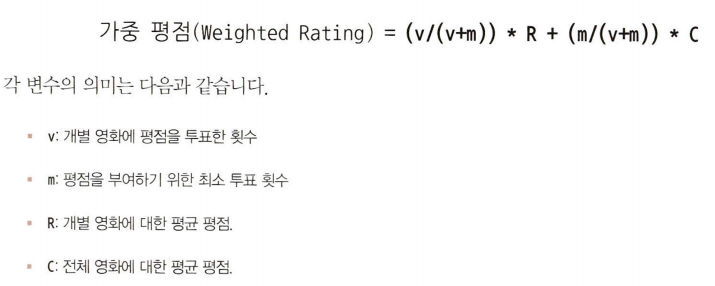

In [27]:
C = movies_df['vote_average'].mean()
m = movies_df['vote_count'].quantile(0.6)  
  # m값을 높이면 평점투표횟수가 많은 영화에 더 많은 가중 평점을 부여
  # 전체 투표 횟수에서 상위 60%에 해당하는 횟수를 기준으로 정함
print('C:', round(C, 3), 'm:', round(m, 3))

C: 6.092 m: 370.2


In [28]:
percentile = 0.6
m = movies_df['vote_count'].quantile(percentile)
C = movies_df['vote_average'].mean()

#기존 평점을 가중 평점으로 변경하는 함수 생성
def weighted_vote_average(record):
  v = record['vote_count']
  R = record['vote_average']

  return ( (v/(v+m)) * R) + ( (m/(m+v)) * C )

movies_df['weighted_vote'] = movies_df.apply(weighted_vote_average, axis=1)

In [29]:
# 가중평균방식으로 새롭게 부여된, 평점 높은 순 상위10

movies_df[['title', 'vote_average', 'weighted_vote', 'vote_count']].sort_values(
    'weighted_vote', ascending=False)[:10]

,title,vote_average,weighted_vote,vote_count
1881,The Shawshank Redemption,8.5,8.396052,8205
3337,The Godfather,8.4,8.263591,5893
662,Fight Club,8.3,8.216455,9413
3232,Pulp Fiction,8.3,8.207102,8428
65,The Dark Knight,8.2,8.136930,12002
1818,Schindler's List,8.3,8.126069,4329
3865,Whiplash,8.3,8.123248,4254
809,Forrest Gump,8.2,8.105954,7927
2294,Spirited Away,8.3,8.105867,3840
2731,The Godfather: Part II,8.3,8.079586,3338


* 위 영화는 유명한 영화. 잘 추출되었다.

In [30]:
# 이제 새롭게 정의된 평점 기준에 따라서 영화를 추천

def find_sim_movie(df, sorted_ind, title_name, top_n=10):
  title_movie = df[df['title'] == title_name]
  title_index = title_movie.index.values

  # 1. top_n의 2배에 해당하는 장르 유사성이 높은 인덱스 추출
  similar_indexes = sorted_ind[title_index, :(top_n*2)]
  similar_indexes = similar_indexes.reshape(-1)
  # 기준 영화 인덱스는 제외
  similar_indexes = similar_indexes[similar_indexes != title_index]

  # 2. top_n의 2배에 해당하는 후보군에서 weighted_vote가 높은 순으로 top_n만큼 추출
  return df.iloc[similar_indexes].sort_values('weighted_vote', ascending=False)[:top_n]

similar_movies = find_sim_movie(movies_df, genre_sim_sorted_ind, 'The Godfather', 10)
similar_movies[['title', 'vote_average', 'weighted_vote']]

,title,vote_average,weighted_vote
2731,The Godfather: Part II,8.3,8.079586
1847,GoodFellas,8.2,7.976937
3866,City of God,8.1,7.759693
1663,Once Upon a Time in America,8.2,7.657811
883,Catch Me If You Can,7.7,7.557097
281,American Gangster,7.4,7.141396
4041,This Is England,7.4,6.739664
1149,American Hustle,6.8,6.717525
1243,Mean Streets,7.2,6.626569
2839,Rounders,6.9,6.530427
